# Proyect 1 - Adaboost (Quintana Gonzalo and Arias Camila)

AdaBoost (short for Adaptative Boosting) is a machine learning algorithm in which the output of other learning algorithms ('weak learners') are combined into a weighted sum that represents the final output. The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing, the final model can be proven to converge to a strong learner.

A boost classifier is a classifier in the form

$F_T(x) = \sum_{t=1}^{T} {\alpha_t h_t(x)} $

where the final classification decision is the linear combination of the decisions of each weak lerner $h_t(x)$.
For example, in the two-class problem, the sign of the weak learner output identifies the predicted object class and the absolute value gives the confidence in that classification. In the following image we can see the representation of this method.

![schema](img1.png)

## Training

At each iteration $t$, a weak learner is generated and asigned a coefficient $ \alpha_t $ such that the sum training error $E_t$ is minimized.

$E_ t = \sum{E[F_{t-1}(x_i) + \alpha_t h(x_i)  ]}$

The particularity of this method is that each weak classifier is trained in order to better perform where the previous classifiers failed and this is what makes this method really powerfull. In order to do this, at each iteration of the training process, a weight $ w_{i,t}$ is assigned to each sample in the training set equal to the current error $ E(F_{t-1}(x_{i})) $ on that sample. These weights are used to inform the weak lerner were it has to focuse.

## First experiments with adaboost

In order to understand how Adaboost makes a prediction, we propose two scenarios. The first one will use a dataset generated using **sklearn datasets** and the second one will use a Pyrat dataset. Let's generate clouds of points with 2 features, 1000 samples and 3 centers which represent the number of classes.

In [85]:
import tqdm
import numpy as np
import ast
import os
from sklearn.datasets import make_blobs
[x,y] = make_blobs(n_samples=1000, n_features=2, centers=3,random_state = 0)

In [6]:
### librarie to plot in python
import matplotlib.pyplot as plt
%matplotlib inline
print("Shape of dataset generated: ", x.shape)

Shape of dataset generated:  (1000, 2)


Text(0.5, 1.0, 'Input data')

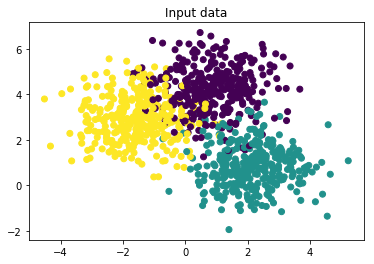

In [9]:
plt.scatter(x[:,0],x[:,1],c=y)
plt.title('Input data')

In order to train and evaluate the classifier we are going to split the dataset in 80% train and 20% test. We use random_state = 0 so that the function always returns the same split.

In [86]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 0,test_size=0.2)
print('Training dataset shape : x{}, y{}'.format(x_train.shape,y_train.shape))
print('Test dataset shape : x{}, y{}'.format(x_test.shape,y_test.shape))

Training dataset shape : x(800, 2), y(800,)
Test dataset shape : x(200, 2), y(200,)


In [8]:
#function to plot boundaries
from matplotlib.colors import ListedColormap
import numpy as np
def plot_boundaries(classifier,X,Y,ax, h=0.2):
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x0, x1 = np.meshgrid(np.arange(x0_min, x0_max,h),
                         np.arange(x1_min, x1_max,h))
    dataset = np.c_[x0.ravel(),x1.ravel()]
    Z = classifier.predict(dataset)

    # Put the result into a color plot
    Z = Z.reshape(x0.shape)
    ax.pcolormesh(x0, x1, Z)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=Y,
                edgecolor='k', s=20)
    ax.xlim(x0.min(), x0.max())
    ax.ylim(x1.min(), x1.max())

### Defining classifiers

Let's use an Adaboost classifier to test whether we can classify this data. To use it with sklearn we import the class [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier). This class implements the algorithm known as Multi-class AdaBoost. We are going to use **Decision Tree Classifier** as weak classifiers. To see how Adaboost works we propose to increase the number of estimators and see how it defines the boundaries each time.

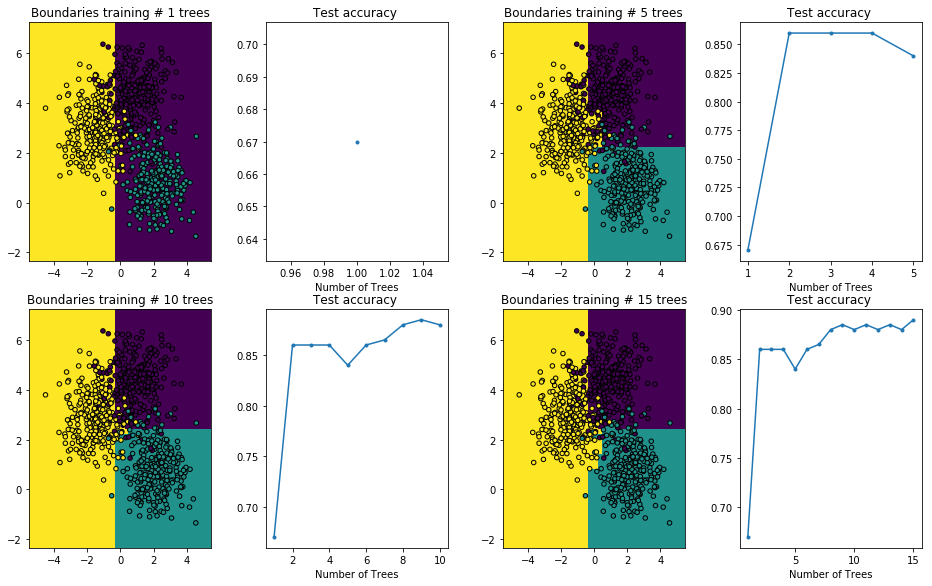

In [87]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

classifiers  = [AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=1),
                AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=5),
                AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=10),
                AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=15)]

fig = plt.figure(figsize=(16,10))


#---------------------- Loop to make the graph from each desired classifier
for i,clf in enumerate(classifiers):
    ax = fig.add_subplot(2,4,2*i +1) 
    clf.fit(x_train,y_train)
    plot_boundaries(clf,x_train,y_train,plt)
    
    #---- evolution each classifier
    acc = []
    for y_pred in clf.staged_predict(x_test): 
        acc.append(accuracy_score(y_pred, y_test)) # --- test error each boosting stage
    n_trees = len(clf) # : number where boosting was completed
    
    plt.title('Boundaries training # {} trees'.format(n_trees))
    ax = fig.add_subplot(2,4,i*2 +2) 
    plt.plot(range(1, n_trees + 1),acc,'.-')
    plt.title('Test accuracy ')
    plt.xlabel('Number of Trees')

plt.subplots_adjust(bottom=0.15, wspace=0.3)

As we can see in the figure above, the accuracy increases as the number of estimators increases. This can also be seen in the boundary plot, where the boundaries get better adapted to the training dataset when the number of trees is incresead. However, if this number of trees is too big, there could be overfitting.

# Effect of the learning rate and the number of trees

In the following section, we are going to compare the accuracy of three AdaBoosts (with different learning rates) while the number of trees increases. The learning rate shrinks the contribution of each classifier. We also compare these accuracies with those of simple decision trees (with maximum depth of 1 and 2). 

We define the different AdaBoosts:

In [89]:
clf_ada = [AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,learning_rate=0.01),
             AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,learning_rate=0.1),
             AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,learning_rate=0.7)]

test = []
for i,clf in enumerate(clf_ada):
    clf.fit(x_train,y_train)    
    #---- evolution each classifier
    test_error = []
    for y_pred in clf.staged_predict(x_test): 
        test_error.append(accuracy_score(y_pred, y_test)) # --- test error each boosting stage    
    test.append(test_error)

    

We define the two decision trees:

In [90]:
clf_tree = [DecisionTreeClassifier(max_depth=1),
           DecisionTreeClassifier(max_depth=2)]
for i,clf in enumerate(clf_tree):
    clf.fit(x_train,y_train)    
    #---- evolution each classifier
    test.append(clf.score(x_test, y_test)*np.ones(200)) # ---

We make the comparaisons:

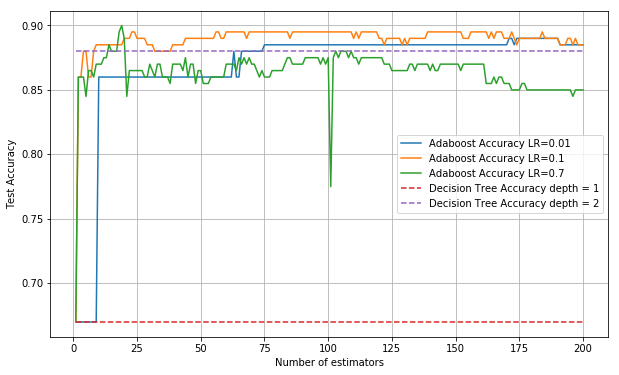

In [91]:
fig = plt.figure(figsize=(10,6))
c = ['-','-','-','--','--']
for i,l in zip(test,c):
    plt.plot(range(1,201),i,l)
    
plt.legend(['Adaboost Accuracy LR=0.01',
            'Adaboost Accuracy LR=0.1',
            'Adaboost Accuracy LR=0.7',
            'Decision Tree Accuracy depth = 1',
            'Decision Tree Accuracy depth = 2'])
plt.ylabel('Test Accuracy')
plt.xlabel('Number of estimators')

plt.grid()

**Observations**
* We can see that we the number of estimators is one, the accuracy is the same of the decision tree of depth 1
* We also can see that the accuracy when having more estimators IS NOT the same as the decision tree of depth 2. This shows that the method is adapting different trees of depth 1 and it is not equivalent to change the tree's depth.
* We can see that the learning rate has a direct effect in the evolution of the accuracy. If it is too small, it will too many estimator to increase the accuracy. If it is too big, the accuracy will start oscillating when increasing the number of estimators.

In order to study how the learning rate affects the boundaries of the decision areas, we plot them in the figure below for 200 estimators.

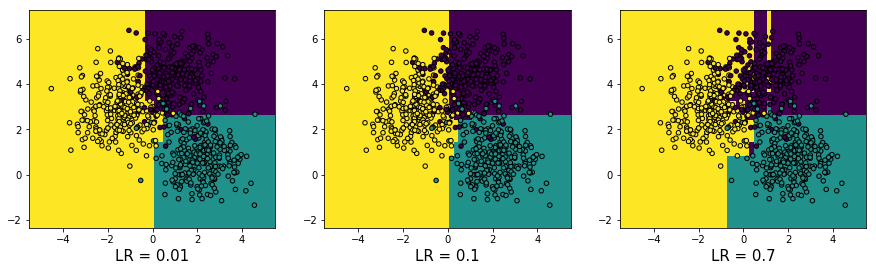

In [92]:
fig = plt.figure(figsize=(15,4))
l = ['LR = 0.01',
    'LR = 0.1',
    'LR = 0.7']
for i,t in enumerate(clf_ada):
    ax = fig.add_subplot(1,3,i+1)
    plot_boundaries(t,x_train,y_train,plt)
    plt.xlabel(l[i],size=15)
    

It can be seen that, as the learning rate increases, the boundaries get more complex. This may have a negative effect, has seen when LR=0,7.

# Application to Pyrat


We apply this method to the problem of predicting the winner in the Pyrat game. We consider the three posible ends as classes. python wins, rat wins and draw.

In [95]:
loaded_data = np.load("dataset.npz")
x_pyrat = loaded_data["x"]
y_pyrat = loaded_data["y"]

In [96]:
print("Input data shape:x{},y{}".format(x_pyrat.shape,y_pyrat.shape))

Input data shape:x(1000, 315),y(1000,)


In [97]:
x_train,x_test,y_train,y_test = train_test_split(x_pyrat,y_pyrat,random_state = 0,test_size=0.2)
print('Training dataset shape : x{}, y{}'.format(x_train.shape,y_train.shape))
print('Test dataset shape : x{}, y{}'.format(x_test.shape,y_test.shape))

Training dataset shape : x(800, 315), y(800,)
Test dataset shape : x(200, 315), y(200,)


In [98]:
clf_py = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100,learning_rate=0.05)
clf_py.fit(x_train,y_train)    
    #---- evolution each classifier
test_error = []
for y_pred in clf_py.staged_predict(x_test): 
    test_error.append(accuracy_score(y_pred, y_test)) # --- test error each boosting stage    


In [99]:
print("Accuracy on the training set {}%".format(clf_py.score(x_train,y_train)*100))
print("Accuracy on the test set {}%".format(clf_py.score(x_test,y_test)*100))

Accuracy on the training set 52.87500000000001%
Accuracy on the test set 50.5%


We calculate the confusion matrix.

Training Set:
             precision    recall  f1-score   support

       -1.0       0.54      0.50      0.52       342
        0.0       0.00      0.00      0.00       101
        1.0       0.52      0.71      0.60       357

avg / total       0.46      0.53      0.49       800

[[170   0 172]
 [ 43   0  58]
 [104   0 253]]


/home/brain/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0,0.5,'Real Class')

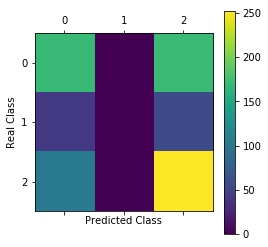

In [100]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred_train = clf_py.predict(x_train)
report = classification_report(y_true=y_train,y_pred=y_pred_train)
matrix = confusion_matrix(y_true=y_train,y_pred=y_pred_train)
print("Training Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()

plt.xlabel("Predicted Class")
plt.ylabel("Real Class")

We can see that the main problem is in the second class, the draw. As we can see, this is possibly due to the fact that the number of samples is too small.

In [111]:
rat_win_index = y_train == -1
draw_index = y_train == 0
python_win_index = y_train == 1

print('Training draw: {},Training rat wins: {},Training python wins: {}'.format(len(y_train[draw_index]),len(y_train[rat_win_index]),len(y_train[python_win_index])))

print('Test draw: {},Test rat wins: {},Test python wins: {}'.format(len(y_test[y_test == 0]),len(y_test[y_test == -1 ]),len(y_test[y_test==1])))

Training draw: 101,Training rat wins: 342,Training python wins: 357
Test draw: 19,Test rat wins: 84,Test python wins: 97


Binary classification
--

We perform now a binary classification between the classes python and rat wins (we don't consider anymore the draws).

In [115]:
## binary classification
x_p = []
y_p = []
for x,y in zip(x_pyrat,y_pyrat):
    if y != 0:
        x_p.append(x)
        y_p.append(y)
x_pyrat_b = np.asarray(x_p)
y_pyrat_b = np.asarray(y_p)

In [116]:
x_train,x_test,y_train,y_test = train_test_split(x_pyrat_b,y_pyrat_b,random_state = 0,test_size=0.2)
print('Training dataset shape : x{}, y{}'.format(x_train.shape,y_train.shape))
print('Test dataset shape : x{}, y{}'.format(x_test.shape,y_test.shape))


Training dataset shape : x(704, 315), y(704,)
Test dataset shape : x(176, 315), y(176,)


In [117]:
clf_py = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100,learning_rate=0.05)
clf_py.fit(x_train,y_train)    
    #---- evolution each classifier
test_error = []
for y_pred in clf_py.staged_predict(x_test): 
    test_error.append(accuracy_score(y_pred, y_test)) # --- test error each boosting stage    


In [118]:
print("Accuracy on the training set {}%".format(clf_py.score(x_train,y_train)*100))
print("Accuracy on the test set {}%".format(clf_py.score(x_test,y_test)*100))

Accuracy on the training set 65.3409090909091%
Accuracy on the test set 51.70454545454546%


Training Set:
             precision    recall  f1-score   support

       -1.0       0.72      0.47      0.57       341
        1.0       0.62      0.83      0.71       363

avg / total       0.67      0.65      0.64       704

[[159 182]
 [ 62 301]]


Text(0,0.5,'Real Class')

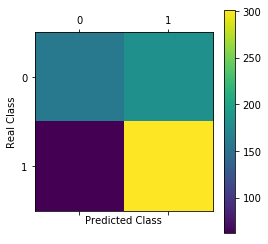

In [119]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred_train = clf_py.predict(x_train)
report = classification_report(y_true=y_train,y_pred=y_pred_train)
matrix = confusion_matrix(y_true=y_train,y_pred=y_pred_train)
print("Training Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()

plt.xlabel("Predicted Class")
plt.ylabel("Real Class")

We can see that the accuracy has now improved. However, there's still a problem in the upper right corner.